## Analyze differences between Tuna Tartare and Beef Tartare through Image Processing

In food_classify.ipynb, we made a MobileNetV2 Convolutional Neural Network (CNN) to perform a classification test on ~50,000 images of dishes. We found that some dishes were easily distinguishable, whereas some were not. In this Jupyter Notebook, we're going to do a simple image processing/computer vision task to determine why Tuna Tartare and Beef Tartare aren't easily distinguishable from another.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import pandas as pd
import umap


c:\Users\super\anaconda3\envs\food_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\super\anaconda3\envs\food_analysis\Lib\site-packages\umap\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Let's read in the dataframe that lists all of the images associated with each food dish and filter out for the tuna tartare and beef tartare dishes. For speed purposes, we'll randomly sample 100 images of each dish:

In [2]:
image_dir = './food-101/images/'

In [3]:
food_df = pd.read_csv('./input_files/all_dishes_df.csv',index_col = 0,header = 0)
food_df.head()

,Absolute Path,File Name,Food Type
0,./food-101/images/apple_pie\2967700.jpg,2967700.jpg,apple_pie
1,./food-101/images/apple_pie\1581853.jpg,1581853.jpg,apple_pie
2,./food-101/images/apple_pie\1375404.jpg,1375404.jpg,apple_pie
3,./food-101/images/apple_pie\2153869.jpg,2153869.jpg,apple_pie
4,./food-101/images/apple_pie\1626685.jpg,1626685.jpg,apple_pie


In [4]:
# Filter for the two classes
tuna_df = food_df[food_df["Food Type"] == "tuna_tartare"]
beef_df = food_df[food_df["Food Type"] == "beef_tartare"]

# Sample a 100 images from each
tuna_paths = tuna_df["Absolute Path"].sample(100, random_state=0).tolist()
beef_paths = beef_df["Absolute Path"].sample(100, random_state=1).tolist()

First off, let's read in a random image of tuna tartare and beef tartare using OpenCV and visually compare them:

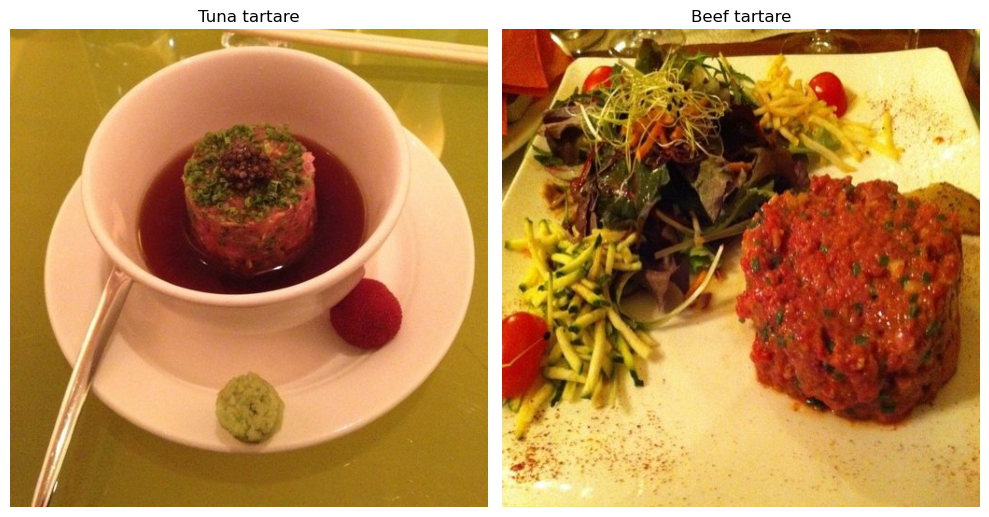

In [5]:
def load_rgb(path):
    """
    This function reads in an image and converts from the blue-green-red color space
    to the red-green-blue colorspace.
    """
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

tuna_img = load_rgb(tuna_paths[0])
beef_img = load_rgb(beef_paths[0])

fig,axes = plt.subplots(figsize = (10,7),ncols = 2)
axes[0].imshow(tuna_img)
axes[0].set_title("Tuna tartare")
axes[0].axis("off")

axes[1].imshow(beef_img)
axes[1].set_title("Beef tartare")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In these representative images (RGB-scale), the shape of tuna tartare and beef tartare are fairly similar to each other. Additionally, we see that the colors are visually similar to. Let's get quantitative measurements of the RGB values for the images:

In [7]:
def mean_rgb(img_rgb):
    """
    This function calculates the mean RGB values in a specific image.
    """
    # img_rgb shape: (Height, Width, 3)
    return img_rgb.reshape(-1, 3).mean(axis=0)

# Calculate mean RGB value for all tuna tartare images
tuna_means = []
for p in tuna_paths:
    img = load_rgb(p)
    tuna_means.append(mean_rgb(img))
tuna_means = np.array(tuna_means)

# Calculate mean RGB value for all beef tartare images
beef_means = []
for p in beef_paths:
    img = load_rgb(p)
    beef_means.append(mean_rgb(img))
beef_means = np.array(beef_means)

print("Tuna mean RGB:", tuna_means.mean(axis=0))
print("Beef mean RGB:", beef_means.mean(axis=0))

Tuna mean RGB: [145.43582749 117.02277751  92.94252857]
Beef mean RGB: [146.86576955 116.42712307  88.06454297]


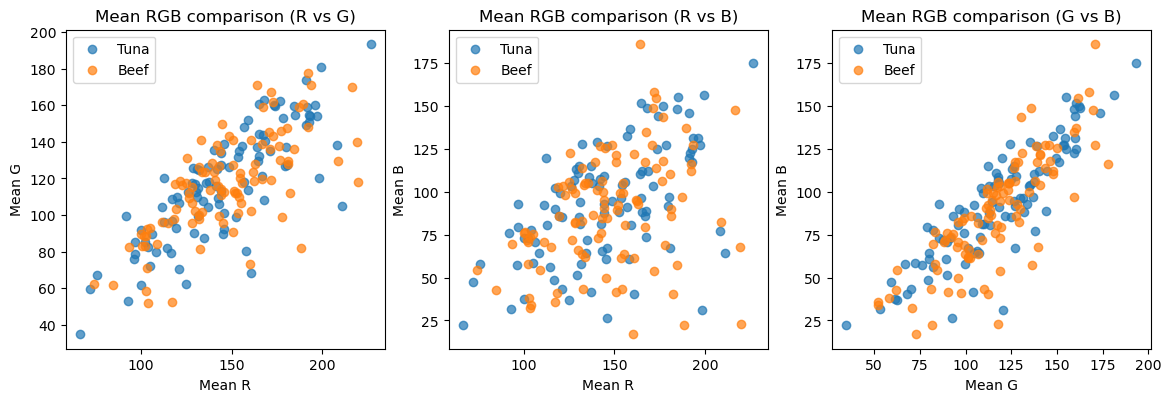

In [8]:

fig,axes = plt.subplots(figsize=(14,6),ncols = 3)

# Red vs. Green values
axes[0].scatter(tuna_means[:,0], tuna_means[:,1], label="Tuna", alpha=0.7)
axes[0].scatter(beef_means[:,0], beef_means[:,1], label="Beef", alpha=0.7)
axes[0].set_xlabel("Mean R")
axes[0].set_ylabel("Mean G")
axes[0].legend()
axes[0].set_title("Mean RGB comparison (R vs G)")
axes[0].set_aspect(np.diff(axes[0].get_xlim())/np.diff(axes[0].get_ylim()))

# Red vs. Blue values
axes[1].scatter(tuna_means[:,0], tuna_means[:,2], label="Tuna", alpha=0.7)
axes[1].scatter(beef_means[:,0], beef_means[:,2], label="Beef", alpha=0.7)
axes[1].set_xlabel("Mean R")
axes[1].set_ylabel("Mean B")
axes[1].legend()
axes[1].set_title("Mean RGB comparison (R vs B)")
axes[1].set_aspect(np.diff(axes[1].get_xlim())/np.diff(axes[1].get_ylim()))

# Green vs. Blue values
axes[2].scatter(tuna_means[:,1], tuna_means[:,2], label="Tuna", alpha=0.7)
axes[2].scatter(beef_means[:,1], beef_means[:,2], label="Beef", alpha=0.7)
axes[2].set_xlabel("Mean G")
axes[2].set_ylabel("Mean B")
axes[2].legend()
axes[2].set_title("Mean RGB comparison (G vs B)")
axes[2].set_aspect(np.diff(axes[2].get_xlim())/np.diff(axes[2].get_ylim()))
plt.show()

As we can see from these scatter plots, there, the RGB values between the tuna and beef tartare are roughly equivalent to each other. Let's look at the distribution of RGB values then:

C:\Users\super\AppData\Local\Temp\ipykernel_25932\3180526570.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


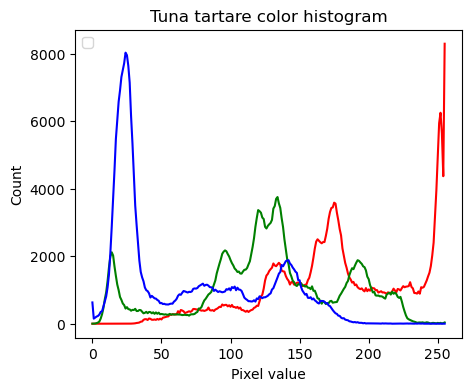

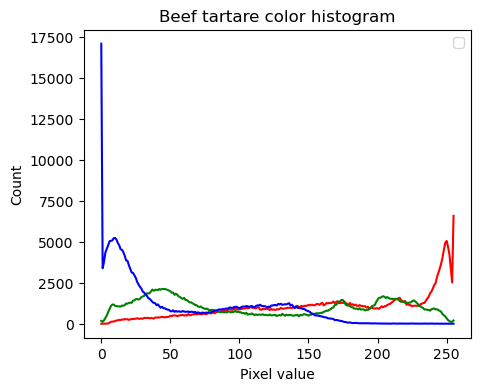

In [9]:
def plot_color_hist(img_rgb, title):
    colors = ('r', 'g', 'b')
    fig,axes = plt.subplots(figsize=(5,4))
    for i, c in enumerate(colors):
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, c=c)
    axes.set_title(title)
    axes.set_xlabel("Pixel value")
    axes.set_ylabel("Count")
    axes.legend()
    plt.show()

plot_color_hist(tuna_img, "Tuna tartare color histogram")
plot_color_hist(beef_img, "Beef tartare color histogram")

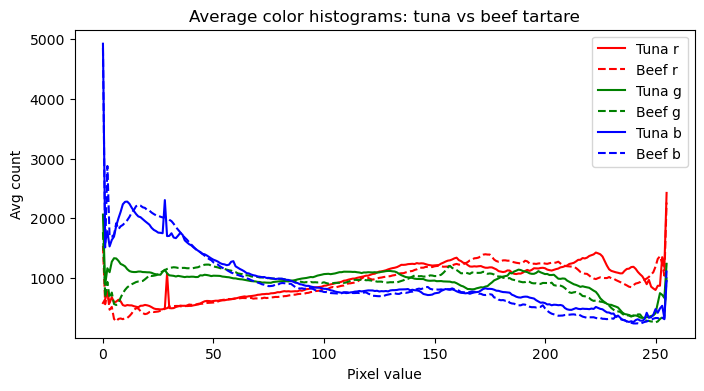

In [10]:
def avg_histogram(paths, bins=256):
    """
    This function creates a histrogram distribution of the average RGB values, using 256 bins.
    """
    acc = np.zeros((3, bins), dtype=np.float32)
    for p in paths:
        img = load_rgb(p)
        for i in range(3):
            h = cv2.calcHist([img], [i], None, [bins], [0,256]).flatten()
            acc[i] += h
    acc /= len(paths)
    return acc

tuna_hist = avg_histogram(tuna_paths)
beef_hist = avg_histogram(beef_paths)

plt.figure(figsize=(8,4))
for i, c in enumerate(('r','g','b')):
    plt.plot(tuna_hist[i], c=c, linestyle='-', label=f"Tuna {c}")
    plt.plot(beef_hist[i], c=c, linestyle='--', label=f"Beef {c}")
plt.legend()
plt.title("Average color histograms: tuna vs beef tartare")
plt.xlabel("Pixel value")
plt.ylabel("Avg count")
plt.show()

As we can see from the histogram, there's little differences in the average RGB values between tuna and beef tartare. Let's try seeing if a UMAP dimensional reduction can distinguish these dishes:

In [5]:
def load_and_flatten(path, size=(128,128)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)

    # flatten: shape becomes (size*size*3,)
    return img.flatten()

# Load images into a feature matrix X and label list Y
X = []
y = []

for p in tuna_paths:
    X.append(load_and_flatten(p))
    y.append("tuna_tartare")

for p in beef_paths:
    X.append(load_and_flatten(p))
    y.append("beef_tartare")

X = np.array(X)
Y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels:", np.unique(Y))

Feature matrix shape: (200, 49152)
Labels: ['beef_tartare' 'tuna_tartare']


c:\Users\super\anaconda3\envs\food_analysis\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\super\anaconda3\envs\food_analysis\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


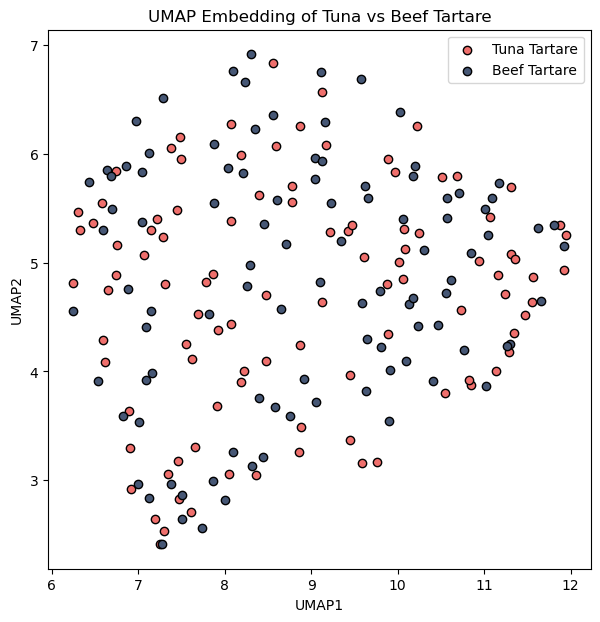

In [8]:
# Make the UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X)

fig,axes = plt.subplots(figsize=(7,7))
axes.scatter(
    X_umap[Y=="tuna_tartare", 0], X_umap[Y=="tuna_tartare", 1],
    c="#EF6F6C", edgecolor = 'black',label="Tuna Tartare", alpha=1)
axes.scatter(
    X_umap[Y=="beef_tartare", 0], X_umap[Y=="beef_tartare", 1],
    c="#465775",edgecolor = 'black', label="Beef Tartare", alpha=1)
axes.legend()
axes.set_title("UMAP Embedding of Tuna vs Beef Tartare")
axes.set_xlabel("UMAP1")
axes.set_ylabel("UMAP2")
plt.savefig('./output_files/umap_tuna_beef_tartare.png',dpi = 200,bbox_inches = 'tight')
plt.show()

Based on our UMAP plot, we can see that there's very little separation between the tuna tartare and beef tartare datapoints, suggesting that they're identical to each other. 

In summary, we've performed basic computer vision/image processing tasks to see if we could find a difference between tuna tartare and steak tartare. Through comparison of their RGB values via histograms and UMAP reduction, we were unable to. 

Other analysis types could include texture analysis, edge-based analysis, FFTs, structural similarity indices, and color variance/entropy analysis to elucidate any potential key differences between tuna tartare and steak tartare.